# Variational AutoEncoders on Fashion MNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import utils

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

## 0. Train parameters

In [9]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
EMBEDDING = 200
LEARNING_RATE = 5e-4
EPOCHS = 10
BETA = 2000

## 1. Prepare dataset

In [5]:
# Preprocess the image
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    return img

# Load CelebA dataset from directory
def get_dataset():
    # read image files from directory
    train_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear'
    )

    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(EPOCHS).shuffle(1024)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds

Found 202599 files belonging to 1 classes.


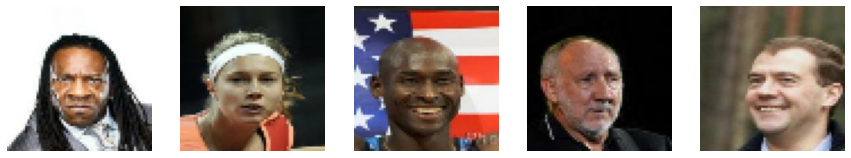

In [6]:
# CHeck dataset
check_ds = get_dataset()
check_samples = next(iter(check_ds))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(check_samples[i])
    axes[i].axis('off')
plt.show()

## 2. Building the Variational AutoEncoder

In [15]:
# Encoder
class Encoder(nn.Module):
    latents: int
    num_blocks: int = 5 # The encoder has 5 identical Conv-BatchNorm-LeakyReLU blocks
    @nn.compact
    
    def __call__(self, x, train:bool):
        for i in range(self.num_blocks):
            x = nn.Conv(features=NUM_FEATURES, kernel_size=(3, 3), strides=2)(x)
            x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.leaky_relu(x)

        x = x.reshape(x.shape[0], -1)
        mean_x = nn.Dense(features=self.latents, name='z_mean')(x)
        logvar_x = nn.Dense(features=self.latents, name='z_logvar')(x)
        return mean_x, logvar_x

encoder = Encoder(EMBEDDING)
print(encoder.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 64, 64, 3)), console_kwargs={'width': 120}, train=False))


                                                    Encoder Summary                                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module    ┃ inputs               ┃ outputs             ┃ batch_stats       ┃ params                    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│             │ Encoder   │ - float32[1,64,64,3] │ - float32[1,200]    │                   │                           │
│             │           │ - train: False       │ - float32[1,200]    │                   │                           │
├─────────────┼───────────┼──────────────────────┼─────────────────────┼───────────────────┼───────────────────────────┤
│ Conv_0      │ Conv      │ float32[1,64,64,3]   │ float32[1,32,32,64] │                   │ bias: float32[64]         │
│             │           │    